In [80]:
!pip install vectorbt
!pip install python-binance

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import vectorbt as vbt
import time
from binance.client import Client
import yfinance as yf
import torch
import torch.nn as nn

| Interval       | Max Lookback Period (approx)  |
|----------------|-------------------------------|
| `'1m'`         | 7 days                        |
| `'2m'`         | 60 days                       |
| `'5m'`         | 60 days                       |
| `'15m'`        | 60 days                       |
| `'30m'`        | 60 days                       |
| `'60m'` / `'1h'` | 730 days (~2 years)        |
| `'1d'`         | ~20+ years                    |
| `'1wk'`        | ~20+ years                    |
| `'1mo'`        | ~20+ years                    |

In [82]:
#data_request = vbt.BinanceData.download("BTCUSDT", start="2025-04-14", end="2025-04-17", interval="1m")
data_request = vbt.YFData.download("BTC-USD", start="2025-04-14", end="2025-04-17", interval="1m")
data = data_request.get()
print(data.head())
print(data["Volume"].iloc[-1])
time.sleep(3)

data_request = data_request.update()
data = data_request.get()
print(data["Volume"].iloc[-1])


                                   Open          High           Low  \
Datetime                                                              
2025-04-14 00:01:00+00:00  83706.945312  83706.945312  83706.945312   
2025-04-14 00:03:00+00:00  83729.085938  83729.085938  83729.085938   
2025-04-14 00:04:00+00:00  83800.125000  83800.125000  83800.125000   
2025-04-14 00:06:00+00:00  83708.820312  83708.820312  83708.820312   
2025-04-14 00:07:00+00:00  83785.421875  83785.421875  83785.421875   

                                  Close     Volume  Dividends  Stock Splits  
Datetime                                                                     
2025-04-14 00:01:00+00:00  83706.945312          0        0.0           0.0  
2025-04-14 00:03:00+00:00  83729.085938  132960256        0.0           0.0  
2025-04-14 00:04:00+00:00  83800.125000  678313984        0.0           0.0  
2025-04-14 00:06:00+00:00  83708.820312   23078912        0.0           0.0  
2025-04-14 00:07:00+00:00  83785.4

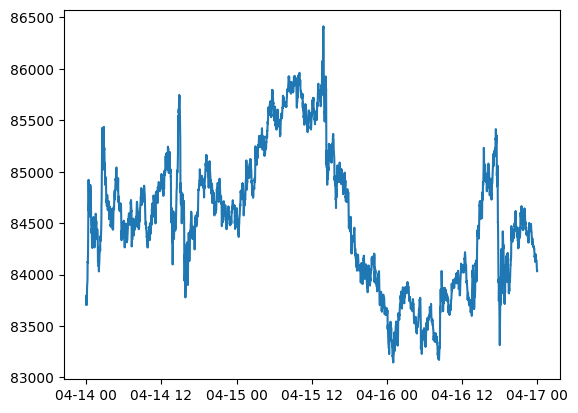

In [132]:
data.vbt.ohlcv.plot(plot_type="candlestick",show_volume=True)
plt.plot(data.index,data["Close"])

size_test_prct = 0.3
lookback = 20 # choose sequence length

input = pd.DataFrame(index = data.index, data = {"Close":data["Close"]})
input = (input-input.min())/(input.max()-input.min())

In [134]:
def split_data(input, lookback, size_test_prct):
    data_raw = np.array(input) # convert to numpy array
    data = []
    lookback+=1 # +1 for output variable

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)

    test_set_size = int(np.round(size_test_prct*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    print(x_train.shape)
    print(y_train.shape)
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    print(x_test.shape)
    print(y_test.shape)

    return [x_train, y_train, x_test, y_test]

In [135]:
lookback = 20 # choose sequence length
size_test_prct = 0.3

x_train, y_train, x_test, y_test = split_data(input, lookback, size_test_prct)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

(2736, 20, 1)
(2736, 1)
(1172, 20, 1)
(1172, 1)


In [136]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [96]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [137]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = np.zeros(num_epochs)
lstm = []

In [138]:
start_time = time.time()

for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time

print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.17832998931407928
Epoch  1 MSE:  0.09367776662111282
Epoch  2 MSE:  0.03788844123482704
Epoch  3 MSE:  0.09774775803089142
Epoch  4 MSE:  0.03831556439399719
Epoch  5 MSE:  0.034132856875658035
Epoch  6 MSE:  0.04272099956870079
Epoch  7 MSE:  0.048618756234645844
Epoch  8 MSE:  0.04978053271770477
Epoch  9 MSE:  0.04733223468065262
Epoch  10 MSE:  0.042882103472948074
Epoch  11 MSE:  0.03794347867369652
Epoch  12 MSE:  0.03388557210564613
Epoch  13 MSE:  0.03189832717180252
Epoch  14 MSE:  0.03262524679303169
Epoch  15 MSE:  0.034941501915454865
Epoch  16 MSE:  0.036038026213645935
Epoch  17 MSE:  0.034628354012966156
Epoch  18 MSE:  0.031746964901685715
Epoch  19 MSE:  0.028995616361498833
Epoch  20 MSE:  0.027155140414834023
Epoch  21 MSE:  0.02609834261238575
Epoch  22 MSE:  0.025221800431609154
Epoch  23 MSE:  0.023746104910969734
Epoch  24 MSE:  0.020815612748265266
Epoch  25 MSE:  0.0157161857932806
Epoch  26 MSE:  0.01002722792327404
Epoch  27 MSE:  0.015414871

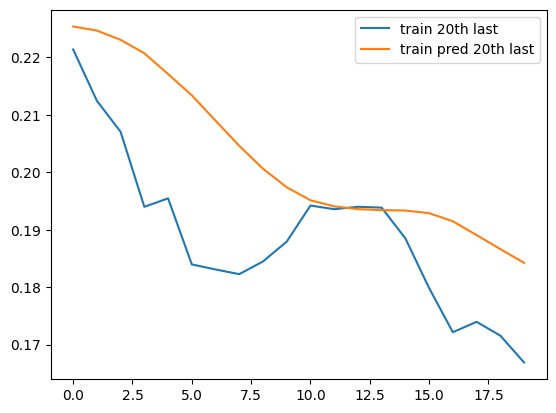

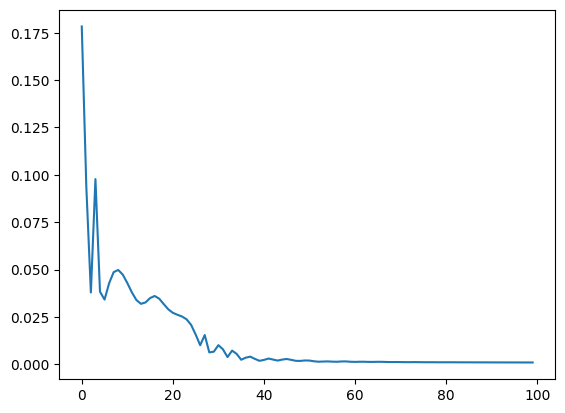

In [164]:
plt.plot(y_train[-lookback:],label=f"train {lookback}th last")
plt.plot(y_train_pred[-lookback:],label=f"train pred {lookback}th last")
plt.legend()
plt.show()

plt.plot(hist)
plt.show()